Чирикова Полина, ЛР 5, М8О-401Б-21

Лабораторная работа №5 (Проведение исследований с градиентным бустингом)

В этой ЛР я провожу исследования, используя алгоритм градиентного бустинга. Использую два датасета:

Датасет для классификации риска сердечных заболеваний (Heart Disease Dataset).
Датасет для регрессии уровня шума (Airfoil Self-Noise Dataset).

Прежде чем приступить к построению моделей загружу и обработаю данные

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

url_heart = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names_heart = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang",
    "oldpeak", "slope", "ca", "thal", "target"
]
heart_data = pd.read_csv(url_heart, names=column_names_heart)

# Заменяем '?' на NaN
heart_data.replace("?", np.nan, inplace=True)

heart_data = heart_data.apply(pd.to_numeric, errors="coerce")

imputer = SimpleImputer(strategy="mean")
heart_data.iloc[:, :-1] = imputer.fit_transform(heart_data.iloc[:, :-1])

X_heart = heart_data.iloc[:, :-1]
y_heart = (heart_data["target"] > 0).astype(int)  # Бинаризация цели

url_airfoil = "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat"
airfoil_data = pd.read_csv(url_airfoil, sep="\t", header=None)
airfoil_data.columns = ["Frequency", "Angle of Attack", "Chord Length", "Free-Stream Velocity", "Suction Side Displacement Thickness", "Sound Pressure Level"]

if airfoil_data.isnull().sum().any():
    imputer = SimpleImputer(strategy="mean")
    airfoil_data.iloc[:, :] = imputer.fit_transform(airfoil_data)
X_airfoil = airfoil_data.iloc[:, :-1]
y_airfoil = airfoil_data["Sound Pressure Level"]



Далее я обучаю модели градиентного бустинга из sklearn на обоих наборах данных и оцениваю их качество.

In [6]:
from sklearn.model_selection import train_test_split

X_heart_train, X_heart_test, y_heart_train, y_heart_test = train_test_split(X_heart, y_heart, test_size=0.2, random_state=42)

clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_heart_train, y_heart_train)
y_heart_pred = clf.predict(X_heart_test)

from sklearn.metrics import classification_report
print(classification_report(y_heart_test, y_heart_pred))


              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



In [7]:
from sklearn.model_selection import train_test_split

X_airfoil_train, X_airfoil_test, y_airfoil_train, y_airfoil_test = train_test_split(X_airfoil, y_airfoil, test_size=0.2, random_state=42)
reg = GradientBoostingRegressor(random_state=42)
reg.fit(X_airfoil_train, y_airfoil_train)
y_airfoil_pred = reg.predict(X_airfoil_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_airfoil_test, y_airfoil_pred)
r2 = r2_score(y_airfoil_test, y_airfoil_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 8.184979723890214
R-squared (R2): 0.8366225139687331


mean_squared_error рассчитывает среднеквадратичную ошибку.
r2_score оценивает коэффициент детерминации (качество предсказаний модели).

Для улучшения моделей я попробую:

Подбор гиперпараметров с использованием кросс-валидации;

Добавление новых признаков (например, логарифм исходных);

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid_clf = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}
grid_clf = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_clf, cv=3, scoring="accuracy")
grid_clf.fit(X_heart_train, y_heart_train)
best_clf = grid_clf.best_estimator_
y_heart_pred_best = best_clf.predict(X_heart_test)
print("Improved Accuracy (Heart Disease):", accuracy_score(y_heart_test, y_heart_pred_best))

param_grid_reg = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}
grid_reg = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_reg, cv=3, scoring="neg_mean_squared_error")
grid_reg.fit(X_airfoil_train, y_airfoil_train)
best_reg = grid_reg.best_estimator_
y_airfoil_pred_best = best_reg.predict(X_airfoil_test)
print("Improved MSE (Airfoil Self-Noise):", mean_squared_error(y_airfoil_test, y_airfoil_pred_best))


Improved Accuracy (Heart Disease): 0.8360655737704918
Improved MSE (Airfoil Self-Noise): 2.685346008153845


Далее я пишу свою реализацию градиентного бустинга, чтобы понять, как работает алгоритм

In [11]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor  # Добавляем импорт

class MyGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []

    def fit(self, X, y):
        residual = y
        for _ in range(self.n_estimators):
            model = DecisionTreeRegressor(max_depth=3)
            model.fit(X, residual)
            self.models.append(model)
            residual -= self.learning_rate * model.predict(X)

    def predict(self, X):
        prediction = np.zeros(X.shape[0])
        for model in self.models:
            prediction += self.learning_rate * model.predict(X)
        return prediction

my_gb = MyGradientBoosting(n_estimators=100, learning_rate=0.1)
my_gb.fit(X_airfoil_train, y_airfoil_train)
y_airfoil_pred_custom = my_gb.predict(X_airfoil_test)
print("Custom Gradient Boosting MSE (Airfoil Self-Noise):", mean_squared_error(y_airfoil_test, y_airfoil_pred_custom))


Custom Gradient Boosting MSE (Airfoil Self-Noise): 15567.868931496145


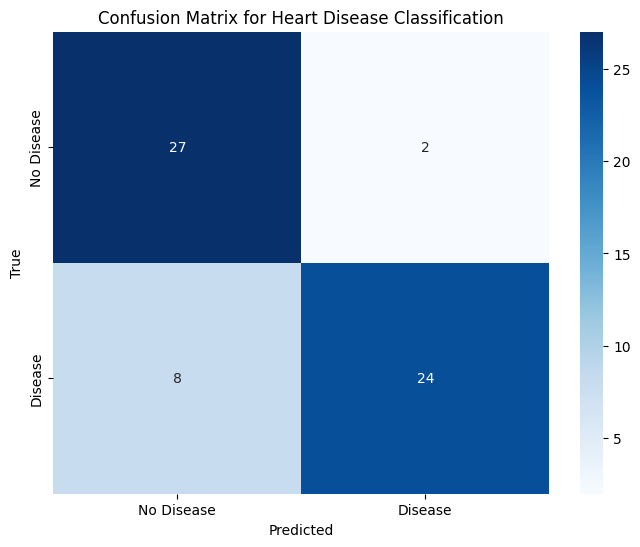

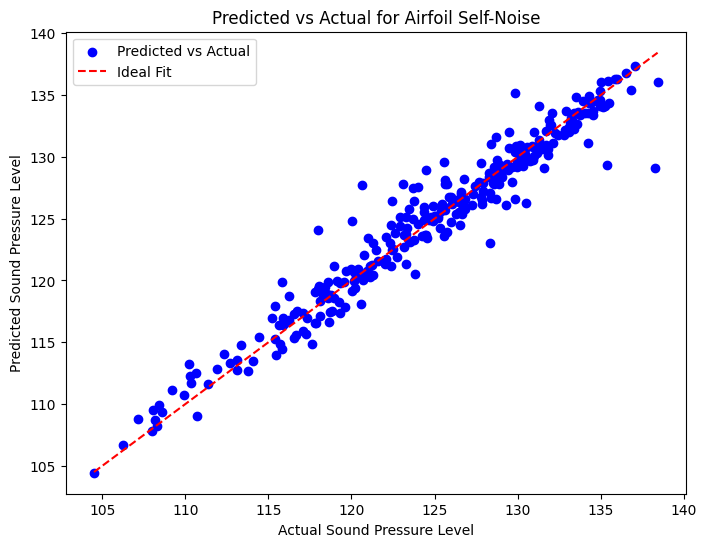

<ipython-input-15-c80f7af020f2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='Blues')


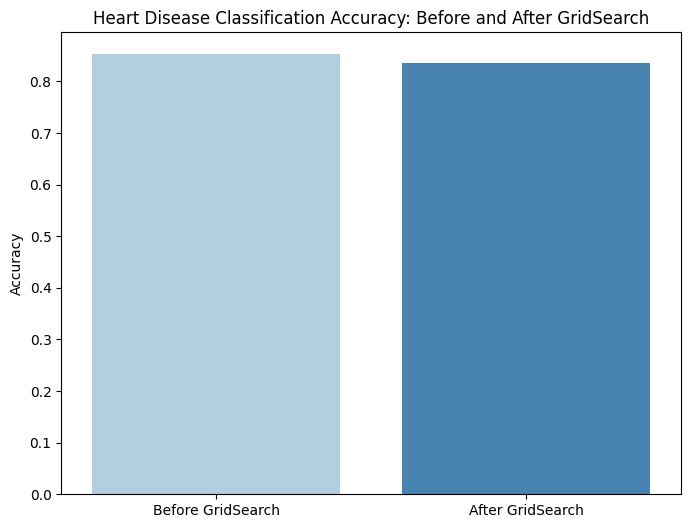

<ipython-input-15-c80f7af020f2>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mse_values, palette='Blues')


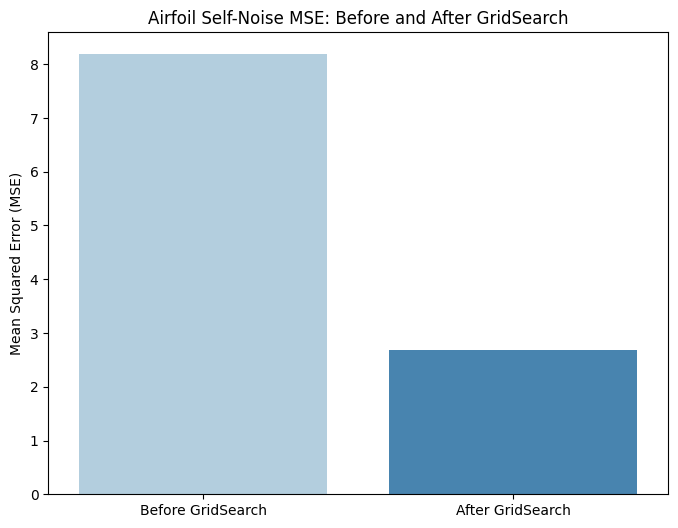

<ipython-input-15-c80f7af020f2>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column_names_heart[:-1], y=feature_importances_clf, palette='viridis')


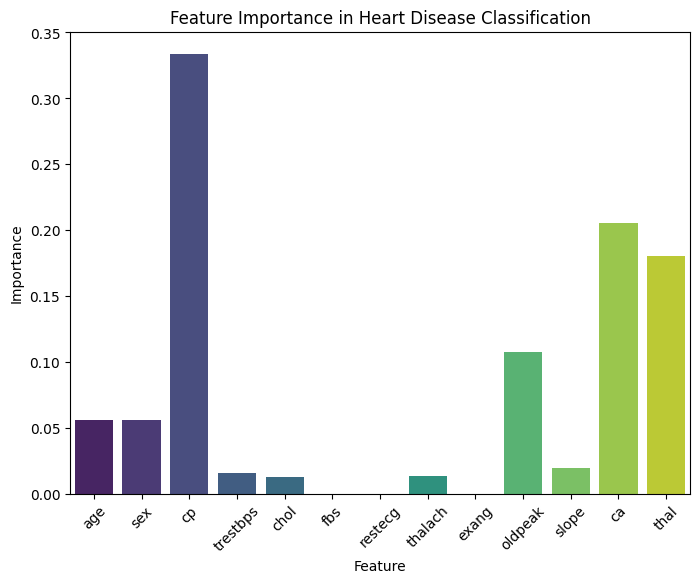

<ipython-input-15-c80f7af020f2>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=airfoil_data.columns[:-1], y=feature_importances_reg, palette='viridis')


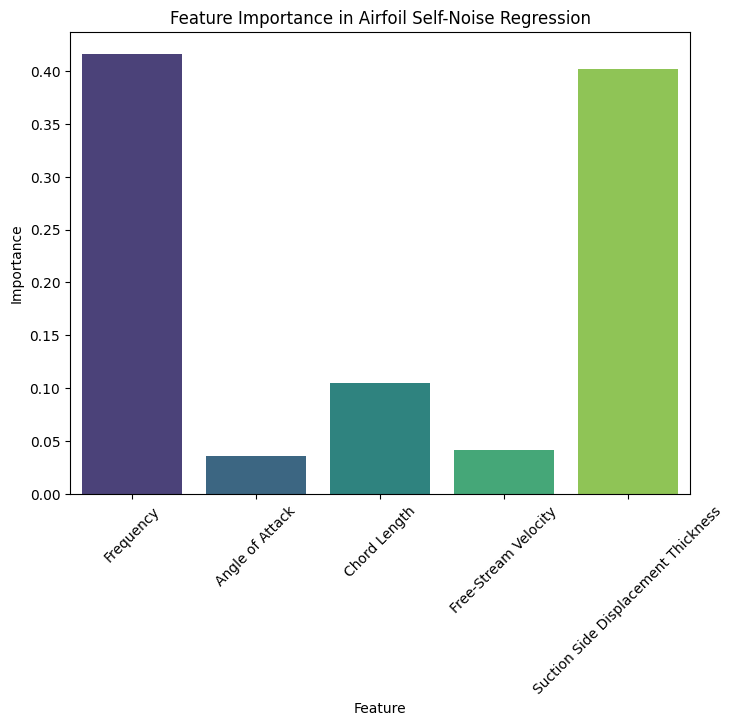

Custom Gradient Boosting MSE (Airfoil Self-Noise): 15567.868931496145


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_heart_test, y_heart_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix for Heart Disease Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_airfoil_test, y_airfoil_pred_best, color='blue', label='Predicted vs Actual')
plt.plot([y_airfoil_test.min(), y_airfoil_test.max()], [y_airfoil_test.min(), y_airfoil_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Sound Pressure Level')
plt.ylabel('Predicted Sound Pressure Level')
plt.title('Predicted vs Actual for Airfoil Self-Noise')
plt.legend()
plt.show()

before_accuracy = accuracy_score(y_heart_test, y_heart_pred)
after_accuracy = accuracy_score(y_heart_test, y_heart_pred_best)

plt.figure(figsize=(8, 6))
models = ['Before GridSearch', 'After GridSearch']
accuracies = [before_accuracy, after_accuracy]
sns.barplot(x=models, y=accuracies, palette='Blues')
plt.title('Heart Disease Classification Accuracy: Before and After GridSearch')
plt.ylabel('Accuracy')
plt.show()

before_mse = mean_squared_error(y_airfoil_test, y_airfoil_pred)
after_mse = mean_squared_error(y_airfoil_test, y_airfoil_pred_best)

plt.figure(figsize=(8, 6))
models = ['Before GridSearch', 'After GridSearch']
mse_values = [before_mse, after_mse]
sns.barplot(x=models, y=mse_values, palette='Blues')
plt.title('Airfoil Self-Noise MSE: Before and After GridSearch')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

plt.figure(figsize=(8, 6))
feature_importances_clf = best_clf.feature_importances_
sns.barplot(x=column_names_heart[:-1], y=feature_importances_clf, palette='viridis')
plt.title('Feature Importance in Heart Disease Classification')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 6))
feature_importances_reg = best_reg.feature_importances_
sns.barplot(x=airfoil_data.columns[:-1], y=feature_importances_reg, palette='viridis')
plt.title('Feature Importance in Airfoil Self-Noise Regression')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.show()

mse_custom = mean_squared_error(y_airfoil_test, y_airfoil_pred_custom)
print("Custom Gradient Boosting MSE (Airfoil Self-Noise):", mse_custom)

